## Translating DBpedia queries to Wikidata with LLMs

In [1]:
# import all the necessary libraries
import re
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from SPARQLWrapper import SPARQLWrapper, JSON
from openai import OpenAI

Create dataset for asking the LLMs

In [7]:
# Load the dataset from 100_complete_entries.json
with open("../../data/100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia
    
    # Extract entities and relations (ER2) in Wikidata
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["wikidata_ids"]  # Only include non-empty Wikidata mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "er2": er2,
            "instruction": "Given the information above, produce a SPARQL query for KG2."
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset.json'.")

Processed dataset saved to 'llm_input_dataset.json'.


## Creating second version of llm input dataset
This version includes an output template in the instruction in order to make it easier to extract the final SPARQL query from the output of the LLMs.

In [5]:
# Load the dataset from 100_complete_entries.json
with open("../../../data/100_complete_entries.json", "r") as file:
    data = json.load(file)

# Create input dataset for the LLM
llm_inputs = []

for entry in data:
    # Extract required fields
    question = entry.get("question", "")  # Natural language question
    dbpedia_query = entry.get("dbpedia_query", "")  # SPARQL query for DBpedia
    
    # Extract entities and relations (ER2) in Wikidata
    er2 = [
        {
            "dbpedia_id": er["dbpedia_id"],
            "wikidata_ids": er["wikidata_ids"]
        }
        for er in entry.get("mapped_entities_relations", {}).get("entities_relations", [])
        if er["wikidata_ids"]  # Only include non-empty Wikidata mappings
    ]
    
    # Skip if there are no valid Wikidata mappings
    if not er2:
        continue

    # Construct the input for the LLM
    llm_input = {
        "context": {
            "natural_language_question": question,
            "sparql_query_kg1": dbpedia_query,
            "kg1_name": "DBpedia",
            "kg2_name": "Wikidata",
            "er2": er2,
            "instruction": "Given the information above, produce a SPARQL query for KG2. In your answer please hightlight the final, complete SPARQL query within the tags '<sparql>' and '</sparql>'."
        }
    }
    llm_inputs.append(llm_input)

# Save the processed dataset to a new JSON file
with open("llm_input_dataset_template.json", "w") as file:
    json.dump(llm_inputs, file, indent=4)

print(f"Processed dataset saved to 'llm_input_dataset_template.json'.")

Processed dataset saved to 'llm_input_dataset_template.json'.


## First test with 100 sample queries
Using meta-llama-3.1-8b-instruct for the first test of translating the queries from DBpedia to Wikidata. The connection works and the model is able to translate the queries. The output is quite large, because the model also explains what as been done. Should the prompt be changed to get a more concise output, only the complete query?

**meta-llama-3.1-8b-instruct is the smallest available model at Academic Cloud https://chat-ai.academiccloud.de/chat, with 8billion parameters**

## Testing meta-llama-3.1-8b-instruct with 100 queries
The model includes 8billion parameters and is one of the samallest available models at Academic Cloud.

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_meta-llama-3.1-8b.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b.json'.


## Testing Mistral-Large-instruct with 100 queries
The model includes 123billion parameters and is the largest available model at Academic Cloud https://chat-ai.academiccloud.de

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_mistral.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral.json'.


## Testing meta-llama-3.1-8b-instruct with 100 queries and the updated query template

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "meta-llama-3.1-8b-instruct"  # Replace with the appropriate model

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_template.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_meta-llama-3.1-8b_template.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_template.json'.")


Translated SPARQL queries for all questions saved to 'translated_llm_output_meta-llama-3.1-8b_template.json'.


## Testing Mistral-Large-instruct with 100 queries and the updated query template

In [ ]:
# Set up the LLM API connection
api_key = '###'
base_url = "https://chat-ai.academiccloud.de/v1"
model = "mistral-large-instruct"

# Start OpenAI client
client = OpenAI(
    api_key=api_key,
    base_url=base_url
)

# Load the input dataset
with open("llm_input_dataset_template.json", "r") as file:
    llm_input_data = json.load(file)

# Initialize the list to store the responses
translated_dataset = []

# Query the LLM for each entry in the dataset
for entry in llm_input_data:
    context = entry["context"]
    
    # Create the prompt for the LLM
    prompt = (
        f"Context:\n"
        f"Natural Language Question: {context['natural_language_question']}\n"
        f"SPARQL Query for KG1 ({context['kg1_name']}):\n"
        f"{context['sparql_query_kg1']}\n"
        f"Knowledge Graph 1 Name: {context['kg1_name']}\n"
        f"Knowledge Graph 2 Name: {context['kg2_name']}\n"
        f"Entity and Relation Mapping (ER2):\n{json.dumps(context['er2'], indent=2)}\n"
        f"Instruction: {context['instruction']}"
    )
    
    try:
        # Query the LLM
        response = client.chat.completions.create(
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            model=model
        )
        
        # Extract the generated SPARQL query from the response
        response_text = response.choices[0].message.content
        
        # Append the response to the translated dataset
        translated_entry = {
            "context": context,
            "sparql_query_kg2": response_text  # Add the translated SPARQL query
        }
        translated_dataset.append(translated_entry)
    
    except Exception as e:
        print(f"Error querying LLM for question ID {context.get('natural_language_question', 'unknown')}: {e}")
        continue

# Save the translated dataset to a new JSON file
with open("translated_llm_output_mistral_template.json", "w") as file:
    json.dump(translated_dataset, file, indent=4)

print("Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_template.json'.")

Error querying LLM for question ID What country is Mount Everest in?: Error code: 502 - {'message': 'An invalid response was received from the upstream server', 'request_id': 'b7d0a4100aa5e60e7de7ca1e417cb378'}
Error querying LLM for question ID Who designed the Brooklyn Bridge?: Model Not Loaded. Please try again in a few minutes.
Translated SPARQL queries for all questions saved to 'translated_llm_output_mistral_template.json'.


## Analysis of the results
For now it can be seen that the extraction process for the larger model (mistral-large-instruct) is working better than for the smaller model (meta-llama-3.1-8b-instruct). The output of the smaller model is not that structured making it harder to extract the queries. On the first sight it also seems that the queries from the larger model are working better.


Extracting the SPARQL queries from LLM output for **mistral-large-instruct**.

In [11]:
# Load the input JSON file
file_path = "translated_llm_output_mistral.json"
with open(file_path, "r") as file:
    data = json.load(file)

# Function to extract SPARQL query from the `sparql_query_kg2` field and remove comments
def extract_sparql_query(entry):
    raw_query = entry.get("sparql_query_kg2", "")
    if not raw_query:
        return None

    # Remove comments starting with `#` and clean up spaces
    cleaned_query = re.sub(r"#.*", "", raw_query)  # Remove everything after `#` on each line
    
    # Extract content between SPARQL code blocks (```sparql and ``` or similar markers)
    match = re.search(
        r"<sparql>\n(.*?)\n</sparql>|"
        r"```\s*<sparql>\s*(.*?)\s*</sparql>\s*```|"
        r"```\s*sparql\s*(.*?)\s*```|"
        r"(SELECT\s+.*?\{.*?\})",  # Capture a valid SPARQL query without explicit markers
        cleaned_query,
        re.DOTALL
    )

    if match:
        # Extract the first non-None group
        query = next(group for group in match.groups() if group is not None)
        return query.replace("\n", " ").strip()  # Remove newline characters and trim whitespace

    return None

# Initialize counts and results tracking
queries_with_context = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Extract SPARQL queries
for entry in data:
    natural_language_question = entry.get("context", {}).get("natural_language_question", "Unknown question")
    sparql_query = extract_sparql_query(entry)

    if sparql_query:
        queries_with_context.append({
            "natural_language_question": natural_language_question,
            "sparql_query_kg2": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": entry.get("sparql_query_kg2", "")
        })

# Save the extracted queries to a new JSON file
output_file = "mistral_wiki_trans_sparql_queries.json"

with open(output_file, "w") as file:
    json.dump(queries_with_context, file, indent=4)

# Print statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")

Cleaned and extracted data has been saved to mistral_wiki_trans_sparql_queries.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


Extracting the SPARQL queries from LLM output for **lama-3.1-8b-instruct**.

In [12]:
input_file_path = 'translated_llm_output_meta-llama-3.1-8b.json'
output_file_path = 'lama_wiki_trans_sparql_queries.json'
# Load the JSON file
with open(input_file_path, 'r') as file:
    data = json.load(file)

# Function to extract and clean SPARQL queries
def extract_and_clean_sparql_query(sparql_raw):
    try:
        if not sparql_raw:
            return None

        # Look for explicitly tagged SPARQL queries
        sparql_match = re.search(r"<sparql>(.*?)</sparql>", sparql_raw, re.DOTALL)

        if not sparql_match:
            # Check for triple-backtick SPARQL code blocks
            sparql_match = re.search(r"```sparql\s*(.*?)\s*```", sparql_raw, re.DOTALL)
        
        if not sparql_match:
            # Check for queries enclosed in single or triple backticks
            sparql_match = re.search(r"```?\s*(SELECT .*?WHERE\s*\{.*?\})\s*```?", sparql_raw, re.DOTALL)
        
        if not sparql_match:
            # Handle cases where the query is embedded in text but not enclosed in markers
            sparql_match = re.search(r"(SELECT\s+.*?WHERE\s*\{.*?\})", sparql_raw, re.DOTALL | re.IGNORECASE)

        if not sparql_match:
            # Handle queries that might have prefixes and end with a closing brace
            sparql_match = re.search(r"(PREFIX\s+.*?WHERE\s*\{.*?\})", sparql_raw, re.DOTALL | re.IGNORECASE)

        if not sparql_match:
            # Attempt to capture queries that may be preceded by an explanation
            sparql_match = re.search(r"SELECT\s+.*?\{.*?\}", sparql_raw, re.DOTALL | re.IGNORECASE)

        if sparql_match:
            # Extract the matched query
            query = sparql_match.group(1).strip()

            # Clean query by removing comments and excess whitespace
            query = re.sub(r"#.*", "", query)  # Remove comments
            query = re.sub(r"\s+", " ", query).strip()  # Remove excessive whitespace and newlines

            # Remove possible enclosing tags or markers
            query = re.sub(r"```sparql|```|<sparql>|</sparql>", "", query).strip()

            return query
    except Exception as e:
        print(f"Error cleaning SPARQL query: {e}")
    
    return None

# Initialize results tracking
result = []
failed_queries = []
total_entries = len(data)
extracted_count = 0

# Process all entries and keep natural language question with the query
for entry in data:
    context = entry.get('context', {})
    natural_language_question = context.get('natural_language_question', None)
    sparql_query_raw = entry.get('sparql_query_kg2', '')

    # Extract and clean the SPARQL query
    sparql_query = extract_and_clean_sparql_query(sparql_query_raw)

    if natural_language_question and sparql_query:
        result.append({
            "natural_language_question": natural_language_question,
            "sparql_query": sparql_query
        })
        extracted_count += 1
    else:
        failed_queries.append({
            "natural_language_question": natural_language_question,
            "sparql_query_raw": sparql_query_raw
        })

# Save the successfully extracted queries to a new JSON file
with open(output_file_path, 'w') as output_file:
    json.dump(result, output_file, indent=4)

# Print statistics
failed_count = total_entries - extracted_count
success_rate = (extracted_count / total_entries) * 100 if total_entries > 0 else 0

print(f"Cleaned and extracted data has been saved to {output_file_path}.")
print(f"Total entries processed: {total_entries}")
print(f"Successfully extracted queries: {extracted_count}")
print(f"Failed queries: {failed_count}")
print(f"Extraction success rate: {success_rate:.2f}%")

Cleaned and extracted data has been saved to lama_wiki_trans_sparql_queries.json.
Total entries processed: 100
Successfully extracted queries: 100
Failed queries: 0
Extraction success rate: 100.00%


## Run the extracted SPARQL queries on Wikidata
Results for **mistral-large-instruct**.

5 Queries are not working, because the syntax is not correct, probably because the extraction process did not work accuratly. Could probably be fixed by manual adjustments. 

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Prefix wikibase was not registered using a PREFIX declaration",\n    "metadata": {\n        "line": 1,\n        "positionInLine": 263,\n        "query": "PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/>  SELECT DISTINCT ?mountain ?mountainLabel ?elevation WHERE {   ?mountain wdt:P31 wd:Q8502 ;             wdt:P131 wd:Q38 ;             wdt:P2044 ?elevation .   SERVICE wikibase:label { bd:serviceParam wikibase:language \\"[AUTO_LANGUAGE],en\\". } } ORDER BY DESC(?elevation) LIMIT 1",\n        "startIndex": 263,\n        "stopIndex": 276\n    },\n    "query": "PREFIX wd: <http://www.wikidata.org/entity/> PREFIX wdt: <http://www.wikidata.org/prop/direct/>  SELECT DISTINCT ?mountain ?mountainLabel ?elevation WHERE {   ?mountain wdt:P31 wd:Q8502 ;             wdt:P131 wd:Q3

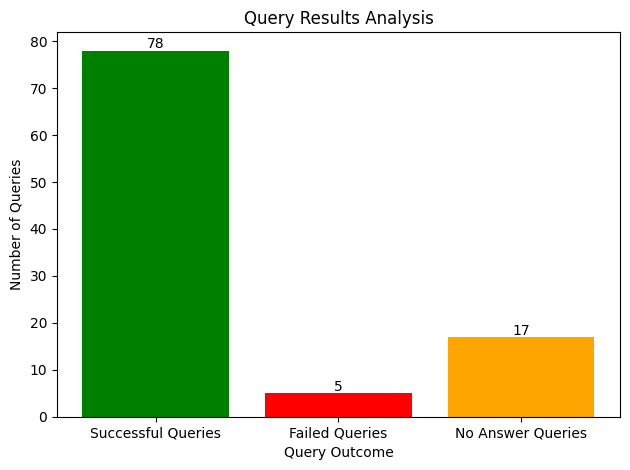

In [13]:
# File paths
input_file_path = "mistral_wiki_trans_sparql_queries.json"
output_file_path = "wikidata_query_results_mistral.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query_kg2", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()

Results for **lama-3.1-8b-instruct**.

Query failed: QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'{\n    "exception": "Invalid SPARQL query: Token \\"*\\": mismatched input \'*\' expecting \'}\'",\n    "metadata": {\n        "line": 8,\n        "positionInLine": 41,\n        "query": "\\nPREFIX wdt: <http://www.wikidata.org/prop/direct/>\\nPREFIX wd: <http://www.wikidata.org/entity/>\\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\\nPREFIX p: <http://www.wikidata.org/prop/>\\nPREFIX ps: <http://www.wikidata.org/prop/statement/>\\nPREFIX pq: <http://www.wikidata.org/prop/qualifier/>\\nSELECT ?uri WHERE { ?uri wdt:P31 wdt:P279* wdt:Q2743 ; wdt:P86 wdt:P279* wdt:Q2808 . }",\n        "startIndex": 339,\n        "stopIndex": 339\n    },\n    "query": "\\nPREFIX wdt: <http://www.wikidata.org/prop/direct/>\\nPREFIX wd: <http://www.wikidata.org/entity/>\\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\\nPREFIX p: <http://www.wikidata.org/prop/>\\n

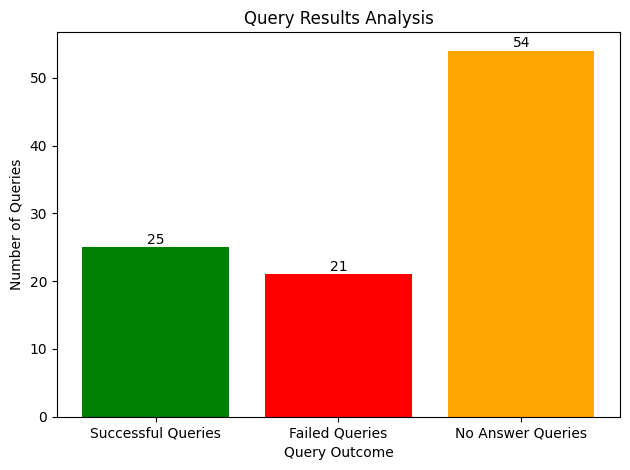

In [14]:
# File paths
input_file_path = "lama_wiki_trans_sparql_queries.json"
output_file_path = "wikidata_query_results_lama.json"

# Wikidata local endpoint
WIKIDATA_ENDPOINT = "http://localhost:7001"

# Define prefixes for the queries
PREFIXES = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX p: <http://www.wikidata.org/prop/>
PREFIX ps: <http://www.wikidata.org/prop/statement/>
PREFIX pq: <http://www.wikidata.org/prop/qualifier/>
"""

# Function to check and prepend prefixes if not present
def ensure_prefixes(query):
    if not query.strip().startswith("PREFIX"):
        return PREFIXES + query
    return query

# Function to query the SPARQL endpoint
def query_sparql(endpoint, query):
    sparql = SPARQLWrapper(endpoint)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    sparql.setMethod('GET')
    sparql.setTimeout(60)
    
    try:
        return sparql.query().convert()  # Return results
    except Exception as e:
        print(f"Query failed: {e}")
        return None

# Extract the answers from the SPARQL query results
def extract_answer(results):
    if not results:
        return ["Query failed"]
    
    if 'boolean' in results:
        return ["True"] if results['boolean'] else ["False"]

    answers = []
    bindings = results.get('results', {}).get('bindings', [])
    for binding in bindings:
        for var_name in binding:
            value = binding[var_name]['value']
            answers.append(value)  # Append the value directly
    return answers if answers else ["No answer"]

# Load the input dataset
with open(input_file_path, "r") as file:
    data = json.load(file)

# Initialize results list
query_results = []

# Process each query in the dataset
for entry in data:
    question = entry.get("natural_language_question", "")
    sparql_query = entry.get("sparql_query", "")
    
    if not sparql_query:
        print(f"No SPARQL query found for question: {question}")
        continue

    # Ensure prefixes are included in the query
    sparql_query_with_prefixes = ensure_prefixes(sparql_query)

    # Execute the query on the Wikidata endpoint
    results = query_sparql(WIKIDATA_ENDPOINT, sparql_query_with_prefixes)
    extracted_answers = extract_answer(results)
    
    # Append the query results
    query_results.append({
        "natural_language_question": question,
        "sparql_query": sparql_query_with_prefixes,
        "answers": extracted_answers
    })

# Save the results to a JSON file
with open(output_file_path, "w") as output_file:
    json.dump(query_results, output_file, indent=4)

print(f"Query results saved to {output_file_path}.")

# Calculate accuracy and categorize results
total_queries = len(data)
successful_queries = sum(1 for result in query_results if "No answer" not in result["answers"] and "Query failed" not in result["answers"])
failed_queries = sum(1 for result in query_results if "Query failed" in result["answers"])
no_answer_queries = sum(1 for result in query_results if "No answer" in result["answers"])
accuracy = (successful_queries / total_queries) * 100 if total_queries > 0 else 0

print(f"Total Queries: {total_queries}")
print(f"Successful Queries: {successful_queries}")
print(f"Failed Queries: {failed_queries}")
print(f"No Answer Queries: {no_answer_queries}")
print(f"Accuracy: {accuracy:.2f}%")

# Visualize results with a bar chart
categories = ['Successful Queries', 'Failed Queries', 'No Answer Queries']
counts = [successful_queries, failed_queries, no_answer_queries]
colors = ['green', 'red', 'orange']

plt.bar(categories, counts, color=colors)
plt.title('Query Results Analysis')
plt.ylabel('Number of Queries')
plt.xlabel('Query Outcome')
for i, count in enumerate(counts):
    plt.text(i, count + 0.5, str(count), ha='center')
plt.tight_layout()
plt.show()


## Thoughts on the results
The results, especially for **lama-3.1-8b-instruct** are not that promesing. The extraction process of the queries from the whole output of the LLM is quite demanding. In the hope to get more reliable results, the second approach, providing the LLM an output template will be tested. This should make the final query extraction easier, and the evaluation of the results more reliable.

## Comparison of wikidata output with original output
In the following the final output of querying Wikidata is compared to the original output of querying QALD9-Plus dataset.

### Comparison lama-3.1-8b-instruct_template with original output

Comparison completed. Results saved to 'comparison_results_llama_zero_shot_dbpedia_wikidata.xlsx'.
Total Queries: 100
Correct Queries: 21
Incorrect Queries (executed but wrong answer): 4
Query Failed to execute: 21
No Answer Queries (executed but empty answer): 54
Accuracy: 21.00%
Execution Success Rate (ESR): 25.00%


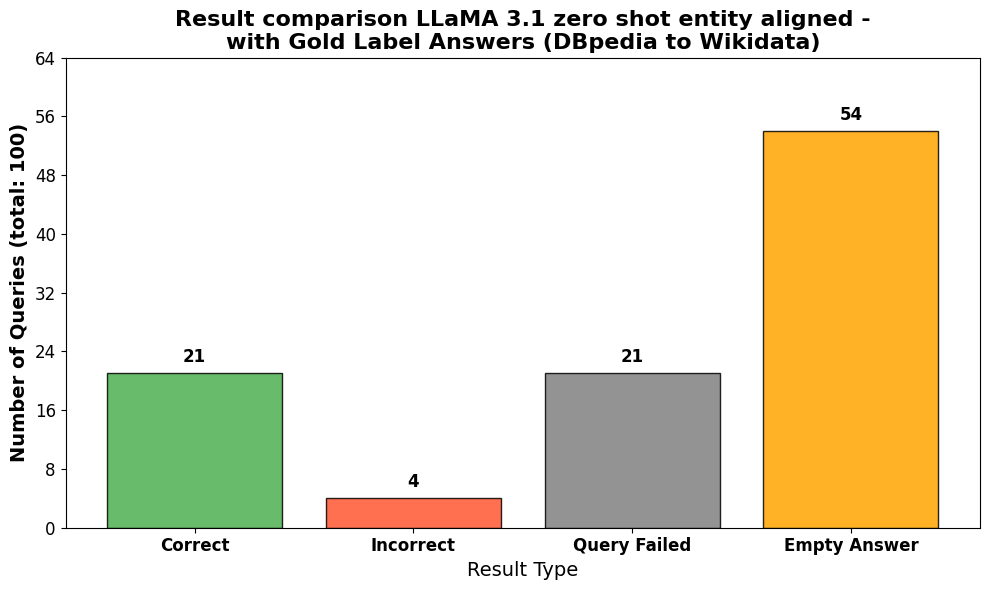

In [16]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "wikidata_query_results_lama.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['wikidata_results'] for entry in solution_data}

# Compare answers
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0  # To calculate Execution Success Rate (ESR)

for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in lama_answers:
        query_failed_count += 1
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if lama_answers and "Query failed" not in lama_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "comparison_results_llama_zero_shot_dbpedia_wikidata.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison LLaMA 3.1 zero shot entity aligned -\nwith Gold Label Answers (DBpedia to Wikidata)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()

### Comparison mistral-large-instruct with original output

Comparison completed. Results saved to 'comparison_results_mistral_zero_shot_dbpedia_wikidata.xlsx'.
Total Queries: 100
Correct Queries: 57
Incorrect Queries (executed but wrong answer): 21
Query Failed to execute: 5
No Answer Queries (executed but empty answer): 17
Accuracy: 57.00%
Execution Success Rate (ESR): 78.00%


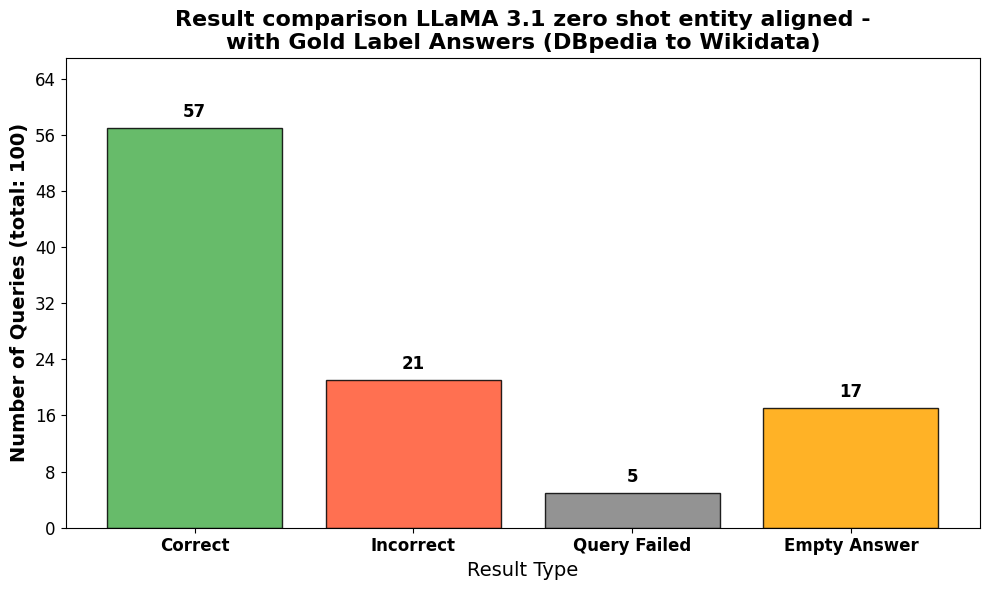

In [17]:
# Define file paths
solution_file_path = "../../../data/100_complete_entries_solution.json"
lama_output_file_path = "wikidata_query_results_mistral.json"

# Load datasets
with open(solution_file_path, 'r') as f:
    solution_data = json.load(f)

with open(lama_output_file_path, 'r') as f:
    lama_output_data = json.load(f)

# Initialize comparison results
comparison_results = []

# Create a mapping of questions to their expected results in the solution dataset
solution_mapping = {entry['question']: entry['wikidata_results'] for entry in solution_data}

# Compare answers
total_questions = len(lama_output_data)
correct_count = 0
incorrect_count = 0
query_failed_count = 0
no_answer_count = 0
successful_executions = 0  # To calculate Execution Success Rate (ESR)

for lama_entry in lama_output_data:
    question = lama_entry.get("natural_language_question")
    lama_answers = lama_entry.get("answers", [])

    # Count query failures and no answers
    if "Query failed" in lama_answers:
        query_failed_count += 1
        continue
    if "No answer" in lama_answers:
        no_answer_count += 1
        continue

    expected_answers = solution_mapping.get(question)
    if expected_answers:
        # Check if all expected answers are in the LLM output and vice versa (ignoring order)
        is_correct = set(expected_answers) == set(lama_answers)
        comparison_results.append({
            "question": question,
            "expected_answers": expected_answers,
            "lama_answers": lama_answers,
            "is_correct": is_correct
        })
        if is_correct:
            correct_count += 1
        else:
            incorrect_count += 1

    # Count successful query executions (any result other than "Query failed")
    if lama_answers and "Query failed" not in lama_answers:
        successful_executions += 1

# Save the results to an Excel file for review
output_excel_file = "comparison_results_mistral_zero_shot_dbpedia_wikidata.xlsx"
results_df = pd.DataFrame(comparison_results)
results_df.to_excel(output_excel_file, index=False)

# Calculate accuracy
accuracy = (correct_count / total_questions) * 100 if total_questions > 0 else 0

# Calculate execution success rate (ESR)
execution_success_rate = (successful_executions / total_questions) * 100 if total_questions > 0 else 0

print(f"Comparison completed. Results saved to '{output_excel_file}'.")
print(f"Total Queries: {total_questions}")
print(f"Correct Queries: {correct_count}")
print(f"Incorrect Queries (executed but wrong answer): {incorrect_count}")
print(f"Query Failed to execute: {query_failed_count}")
print(f"No Answer Queries (executed but empty answer): {no_answer_count}")
print(f"Accuracy: {accuracy:.2f}%")
print(f"Execution Success Rate (ESR): {execution_success_rate:.2f}%")

# Visualize the results
categories = ['Correct', 'Incorrect', 'Query Failed', 'Empty Answer']
counts = [correct_count, incorrect_count, query_failed_count, no_answer_count]
colors = ['#4CAF50', '#FF5733', '#808080', '#FFA500']

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(categories, counts, color=colors, alpha=0.85, edgecolor='black')

# Annotate bars with their values
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 1, str(height), ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configure y-axis to show only integer values with total queries in parentheses
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_ylabel(f'Number of Queries (total: {total_questions})', fontsize=14, fontweight='bold')

# Add title and labels with improved aesthetics
plt.title('Result comparison LLaMA 3.1 zero shot entity aligned -\nwith Gold Label Answers (DBpedia to Wikidata)', fontsize=16, fontweight='bold')
plt.xlabel('Result Type', fontsize=14)

# Enhance visual appeal
plt.grid(axis='y', linestyle='', alpha=0.7)
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)
plt.ylim(0, max(counts) + 10)

# Show the plot
plt.tight_layout()
plt.show()

## Thoughts on the results
Looking at the results it can be seen, that there are still some answers not matching the original answers. This could be due to the fact that the queries are not translated correctly. Taking a closer look the mostly the "incorrect" anwsers are still matching but include more results (wikidata entities) or less, then the original answers. In only few cases it can be seen that the query lead to missleading results of example: 
- "What is the most frequent cause of death?" - the original answer is "myocardial infarction" and the mistral answer is "roadkill (animals that have been killed by cars at high speed)". **This is a clear mistake.**
- "For which label did Elvis record his first album?" - the original answer is "RCA Records" and the mistral answer is "RCA Victor". **This is a some how correct answer.**
- "Give me all companies in the advertising industry." - the original shows all companies with entries and the mistral answer is just the number "134". 
- "Give me the capitals of all countries that the Himalayas run through." - the output of the mistral is longer counting two more capitals than the original answer. 